 # This notebook shows the expierments done to identify, mitigate and understand the interpretability of Machine Learning Models on UCI Dataset

## Logistic Regression


 Validation Metrics
Accuracy : 0.8108108108108109
Precision: 0.8181818181818182
Recall   : 0.8181818181818182
F1 Score : 0.8181818181818182
ROC AUC  : 0.8966526431315164

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        71
           1       0.82      0.82      0.82        77

    accuracy                           0.81       148
   macro avg       0.81      0.81      0.81       148
weighted avg       0.81      0.81      0.81       148



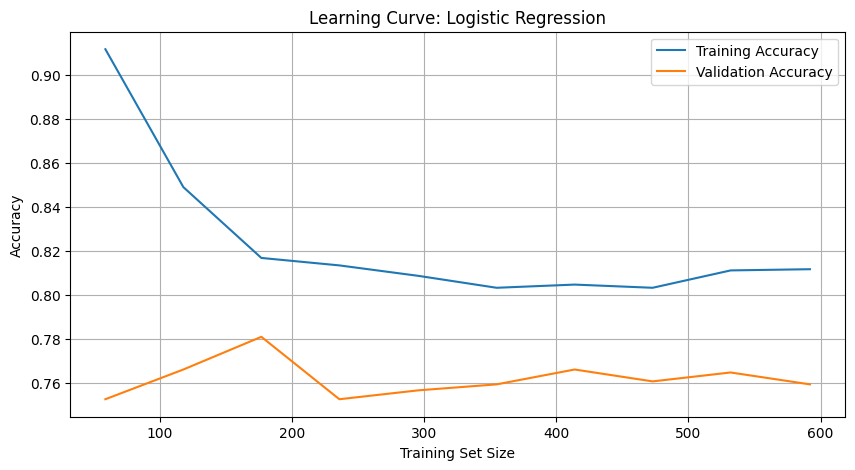

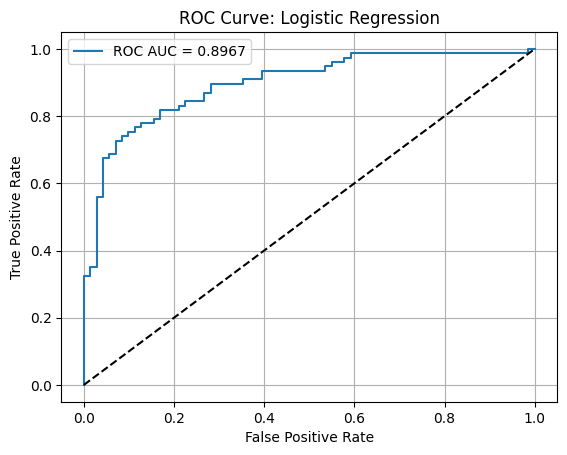

In [14]:
# Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Loading the dataset
df = pd.read_csv("/content/heart_disease_uci.csv")

#Dropping ID and high-missing columns
df = df.drop(columns=["id", "dataset", "slope", "ca", "thal"])

#Dropping rows with any missing values
df = df.dropna()
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=["num"], inplace=True)

# Splitting into Features and target
X = df.drop("target", axis=1)
y = df["target"]

#Converting 'object' type columns to categorical codes
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype("category").cat.codes

#Converting 'category' type columns to numerical codes
for col in X.select_dtypes(include='category').columns:
    X[col] = X[col].cat.codes

#Fearure scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Splitting the dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

#Training Logistic Regression
lr = LogisticRegression(max_iter=1000, penalty='l2', C=1.0, solver='lbfgs')
lr.fit(X_train, y_train)
y_val_pred = lr.predict(X_val) #Predicting the values
y_val_proba = lr.predict_proba(X_val)[:, 1]

print("\n Validation Metrics")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Plotting the Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=lr, X=X_scaled, y=y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', shuffle=True, random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.title("Learning Curve: Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#Plotting the ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_val, y_val_proba):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


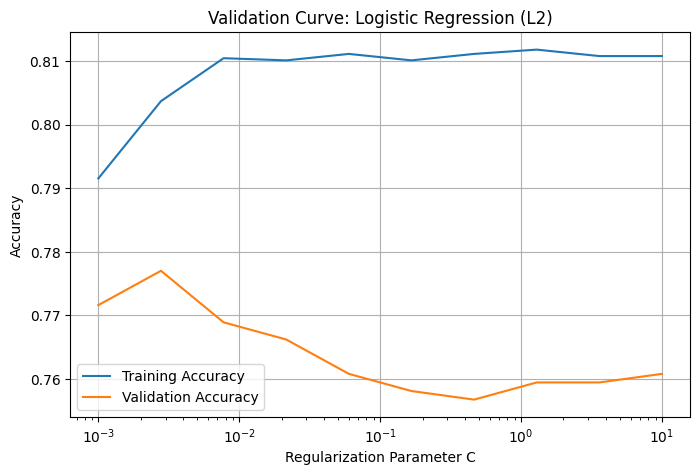

In [ ]:
#Here now we compare different regularization strengths (C values)
from sklearn.model_selection import validation_curve

C_range = np.logspace(-3, 1, 10)
train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs'),
    X_scaled, y, param_name="C", param_range=C_range,
    scoring="accuracy", cv=5
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

#Plotting validation curve
plt.figure(figsize=(8, 5))
plt.semilogx(C_range, train_mean, label="Training Accuracy")
plt.semilogx(C_range, val_mean, label="Validation Accuracy")
plt.xlabel("Regularization Parameter C")
plt.ylabel("Accuracy")
plt.title("Validation Curve: Logistic Regression (L2)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Trying L1-Regularized Logistic Regression (Lasso)
from sklearn.linear_model import LogisticRegression

lr_l1 = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', max_iter=1000) # Using liblinear solver for L1
lr_l1.fit(X_train, y_train)

y_val_pred_l1 = lr_l1.predict(X_val) # Evaluating
y_val_proba_l1 = lr_l1.predict_proba(X_val)[:, 1]

print("\nL1 Validation Metrics")
print("Accuracy :", accuracy_score(y_val, y_val_pred_l1))
print("Precision:", precision_score(y_val, y_val_pred_l1))
print("Recall   :", recall_score(y_val, y_val_pred_l1))
print("F1 Score :", f1_score(y_val, y_val_pred_l1))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba_l1))

# Checking the sparsity in coefficients
coef_df = pd.DataFrame({
    "Feature": df.drop(columns=["target"]).columns,
    "Coefficient": lr_l1.coef_[0]
})
coef_df["Zeroed"] = coef_df["Coefficient"] == 0
print("\nCoefficient Sparsity:\n", coef_df.sort_values("Coefficient", key=abs, ascending=False))



L1 Validation Metrics
Accuracy : 0.75
Precision: 0.8125
Recall   : 0.6753246753246753
F1 Score : 0.7375886524822695
ROC AUC  : 0.8395829522590086

Coefficient Sparsity:
     Feature  Coefficient  Zeroed
8     exang     0.278705   False
9   oldpeak     0.024438   False
7    thalch    -0.014267   False
0       age     0.000000    True
1       sex     0.000000    True
2        cp     0.000000    True
5       fbs     0.000000    True
4      chol     0.000000    True
3  trestbps     0.000000    True
6   restecg     0.000000    True


ExactExplainer explainer: 149it [00:10,  1.29it/s]                         


<Figure size 640x480 with 0 Axes>

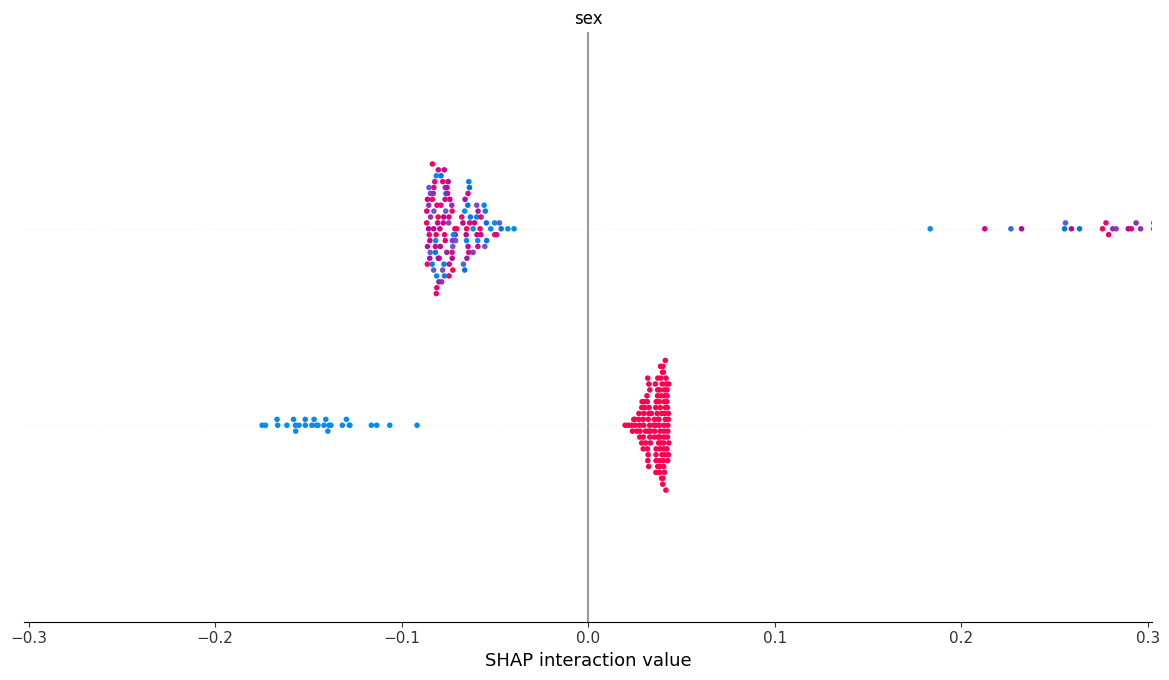

<Figure size 640x480 with 0 Axes>

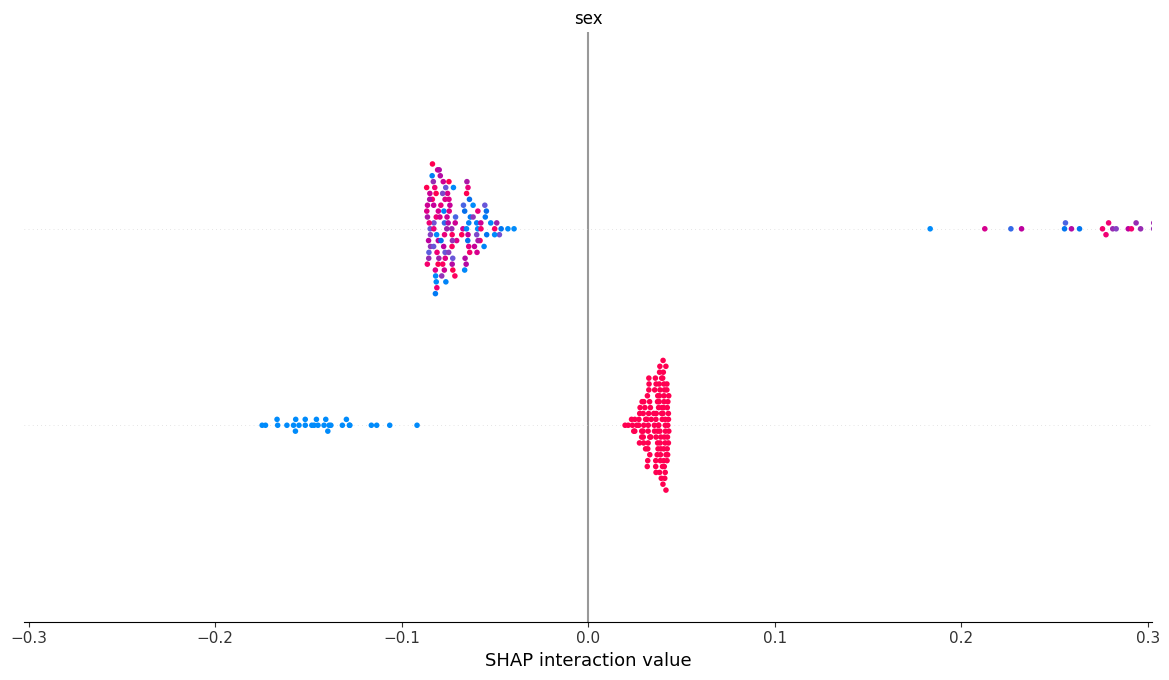

In [ ]:
# To understand interpetabiloty using SHAP
# !pip install shap --quiet

import shap #Installing and importing

# Creating explainer using kernel SHAP
explainer = shap.Explainer(lr.predict_proba, X_val, feature_names=X.columns) #(since LR is linear)
shap_values = explainer(X_val)

# Running the SHAP Summary
shap.summary_plot(shap_values, features=X_val, feature_names=X.columns)
shap.summary_plot(shap_values, features=X_val, feature_names=X.columns, plot_type="bar")


## Random Forest

In [17]:
#Importing required Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import shap

#Loading the dataste
df = pd.read_csv("/content/heart_disease_uci.csv")

# Preprocessing
df = df.drop(columns=["id", "dataset", "slope", "ca", "thal"])
df = df.dropna()
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=["num"], inplace=True)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() #Using this to convert all object-type (string) columns to numeric
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


X = df.drop("target", axis=1)
y = df["target"]

# Splitting the dataset into Training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [18]:
# Training the RF
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val) #Predicting the values
y_proba = rf.predict_proba(X_val)[:, 1]

print("RF Baseline Metrics")
print("Accuracy :", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall   :", recall_score(y_val, y_pred))
print("F1 Score :", f1_score(y_val, y_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_proba))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


RF Baseline Metrics
Accuracy : 0.831081081081081
Precision: 0.8333333333333334
Recall   : 0.8441558441558441
F1 Score : 0.8387096774193549
ROC AUC  : 0.8862264496067314

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.83      0.84      0.84        77

    accuracy                           0.83       148
   macro avg       0.83      0.83      0.83       148
weighted avg       0.83      0.83      0.83       148



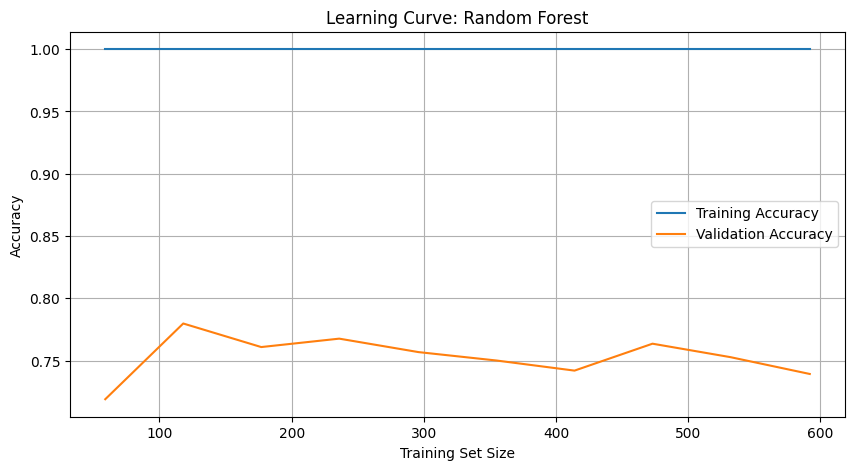

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    rf, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.title("Learning Curve: Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


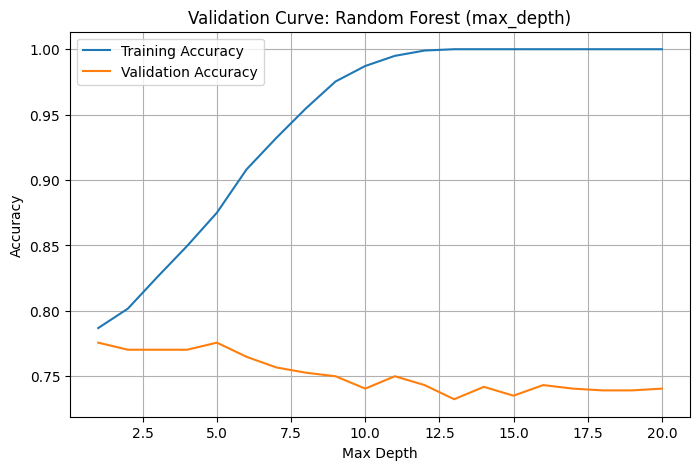

In [ ]:
# Running the Validation Curve for max_depth
from sklearn.model_selection import validation_curve

depth_range = range(1, 21)
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X, y,
    param_name="max_depth",
    param_range=depth_range,
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(depth_range, train_mean, label='Training Accuracy')
plt.plot(depth_range, val_mean, label='Validation Accuracy')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Validation Curve: Random Forest (max_depth)")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Retrainning with tuned hyperparameters
rf_tuned = RandomForestClassifier(
    max_depth=6,            # Thsi is based on curve
    min_samples_leaf=5,     # This helps prevent overfitting
    random_state=42
)
rf_tuned.fit(X_train, y_train)

# Evaluating the model again
y_pred_tuned = rf_tuned.predict(X_val)
y_proba_tuned = rf_tuned.predict_proba(X_val)[:, 1]

print("Tuned RF Metrics")
print("Accuracy :", accuracy_score(y_val, y_pred_tuned))
print("Precision:", precision_score(y_val, y_pred_tuned))
print("Recall   :", recall_score(y_val, y_pred_tuned))
print("F1 Score :", f1_score(y_val, y_pred_tuned))
print("ROC AUC  :", roc_auc_score(y_val, y_proba_tuned))


Tuned RF Metrics
Accuracy : 0.8175675675675675
Precision: 0.8125
Recall   : 0.8441558441558441
F1 Score : 0.8280254777070064
ROC AUC  : 0.8948234863727822


<Figure size 640x480 with 0 Axes>

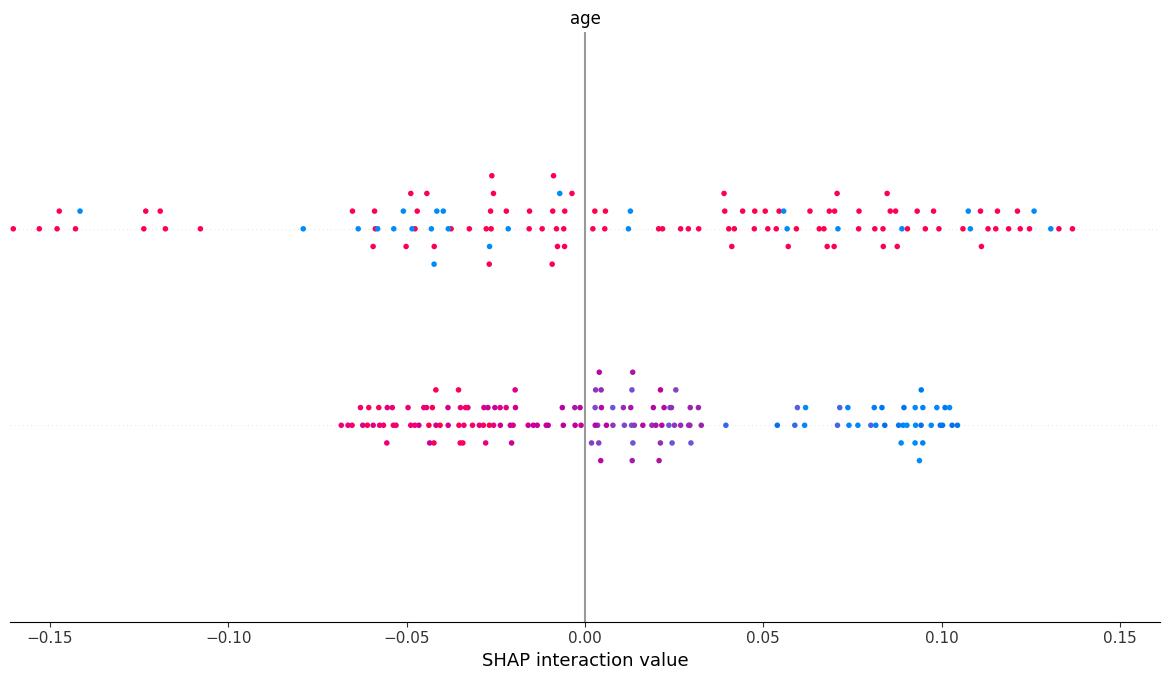

<Figure size 640x480 with 0 Axes>

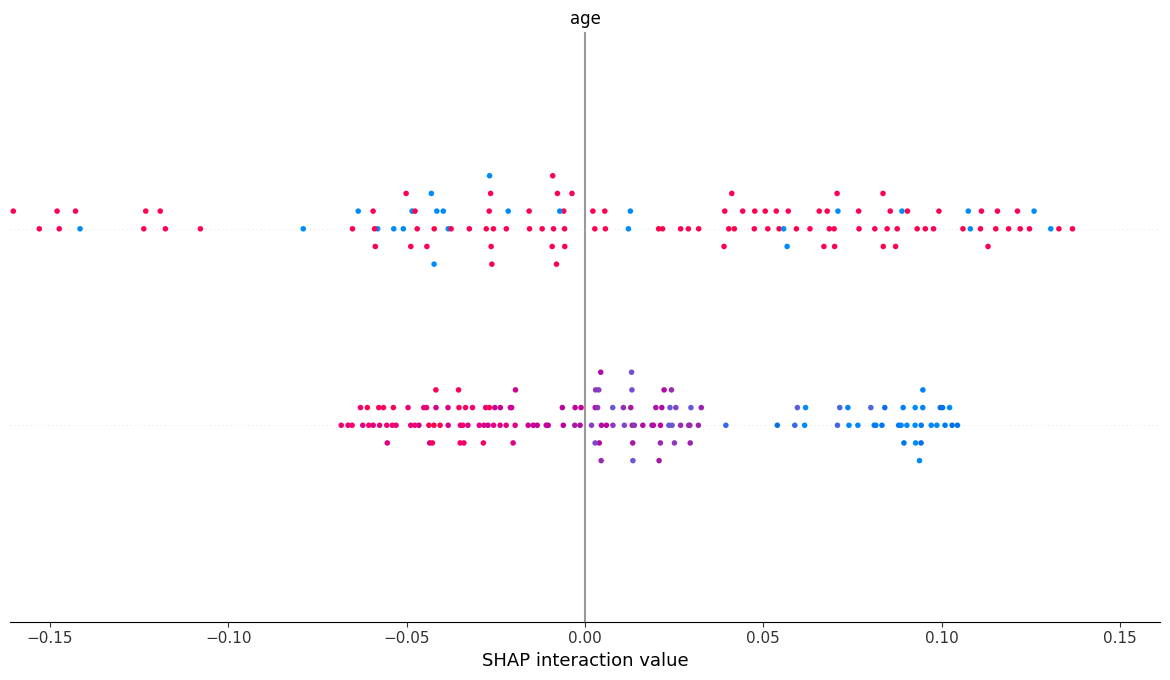

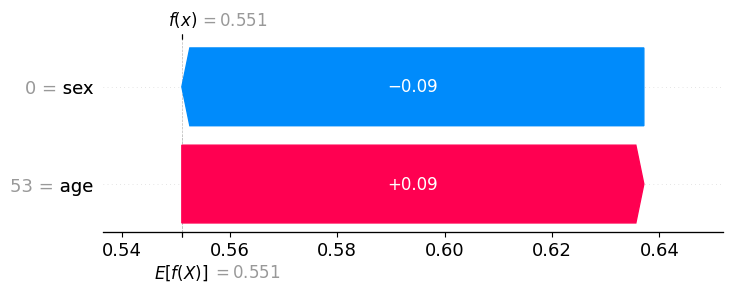

In [ ]:
# Performing SHAP for Tuned Random Forest
import shap

# SHAP TreeExplainer is optimized for tree models
explainer_rf = shap.Explainer(rf_tuned, X_val)
shap_values_rf = explainer_rf(X_val)
shap.summary_plot(shap_values_rf, features=X_val, feature_names=X.columns) #Interpretability check

#Bar version for global importance
shap.summary_plot(shap_values_rf, features=X_val, feature_names=X.columns, plot_type="bar")


shap.plots.waterfall(shap.Explanation(
    values=shap_values_rf.values[0, 1],
    base_values=shap_values_rf.base_values[0, 1],
    data=shap_values_rf.data[0],
    feature_names=X.columns
))



## SVM

In [20]:
#Importing requied libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

# Loading the dataset
df = pd.read_csv("/content/heart_disease_uci.csv")
df.drop(columns=["id", "dataset"], errors="ignore", inplace=True)
df.rename(columns={"num": "target"}, inplace=True)

# Converting the target to binary
df["target"] = (df["target"] > 0).astype(int)

# Splitting the features and target
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_combined = pd.concat([X_train, X_val])

# Imputing missing values...Here we use mean for numeric, most frequent for others
imputer = SimpleImputer(strategy='most_frequent')
X_combined_imputed = pd.DataFrame(imputer.fit_transform(X_combined), columns=X_combined.columns)

#One-hot encode categoricals
X_combined_encoded = pd.get_dummies(X_combined_imputed)

# Splitting into training and validation sets
X_train_encoded = X_combined_encoded.iloc[:len(X_train), :]
X_val_encoded = X_combined_encoded.iloc[len(X_train):, :]

#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

print("X_train_scaled:", X_train_scaled.shape) #Debugging Check
print("y_train:", y_train.shape)

#Training SVM
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train)


y_val_pred = svm_clf.predict(X_val_scaled) #Evaluate on validation
y_val_proba = svm_clf.predict_proba(X_val_scaled)[:, 1]

print("\n Validation Metrics")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluating on train to check for overfitting - Yes
y_train_pred = svm_clf.predict(X_train_scaled)
y_train_proba = svm_clf.predict_proba(X_train_scaled)[:, 1]

print("\nTrain Metrics")
print("Accuracy :", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall   :", recall_score(y_train, y_train_pred))
print("F1 Score :", f1_score(y_train, y_train_pred))
print("ROC AUC  :", roc_auc_score(y_train, y_train_proba))


X_train_scaled: (736, 523)
y_train: (736,)

 Validation Metrics
Accuracy : 0.8043478260869565
Precision: 0.7894736842105263
Recall   : 0.8823529411764706
F1 Score : 0.8333333333333334
ROC AUC  : 0.8736250597800096

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.76        82
           1       0.79      0.88      0.83       102

    accuracy                           0.80       184
   macro avg       0.81      0.79      0.80       184
weighted avg       0.81      0.80      0.80       184

Confusion Matrix:
 [[58 24]
 [12 90]]

Train Metrics
Accuracy : 0.9633152173913043
Precision: 0.9481132075471698
Recall   : 0.9877149877149877
F1 Score : 0.9675090252707581
ROC AUC  : 0.9903213520234797


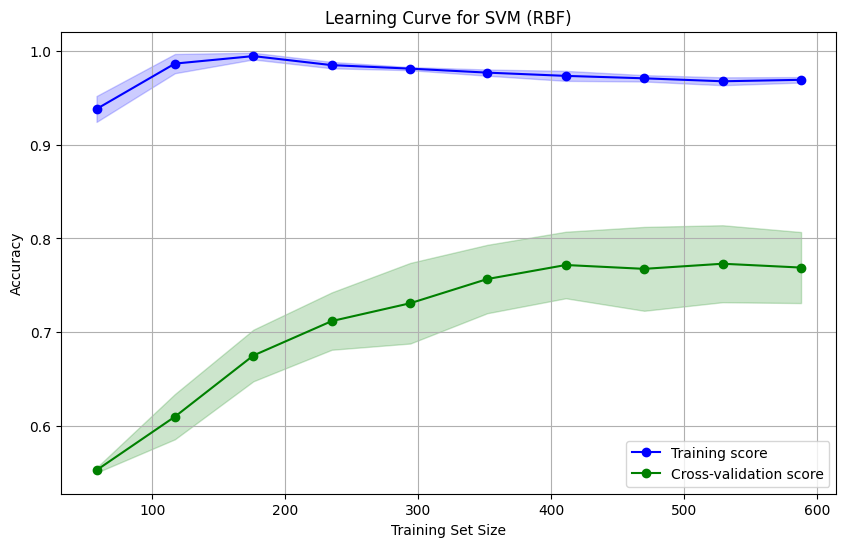

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

#Now Using learning_curve to get scores at different training sizes
train_sizes, train_scores, val_scores = learning_curve(
    SVC(kernel='rbf', probability=True, random_state=42),
    X_train_scaled,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

#Computing mean and std for error bars
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color="green")

plt.title("Learning Curve for SVM (RBF)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


In [21]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline

# Chaning Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=30)  # Trying 20–50

# SAme SVM model
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

# Building the Pipeline
svm_pipeline = Pipeline([
    ('select', selector),
    ('scale', StandardScaler()),
    ('svm', svm_model)
])

svm_pipeline.fit(X_train_encoded, y_train) #Training the model

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

y_val_pred = svm_pipeline.predict(X_val_encoded) #Evaluating
y_val_proba = svm_pipeline.predict_proba(X_val_encoded)[:, 1]

print("\nFeature-Selected SVM Validation Metrics")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))



Feature-Selected SVM Validation Metrics
Accuracy : 0.8097826086956522
Precision: 0.8130841121495327
Recall   : 0.8529411764705882
F1 Score : 0.8325358851674641
ROC AUC  : 0.8726087996174078


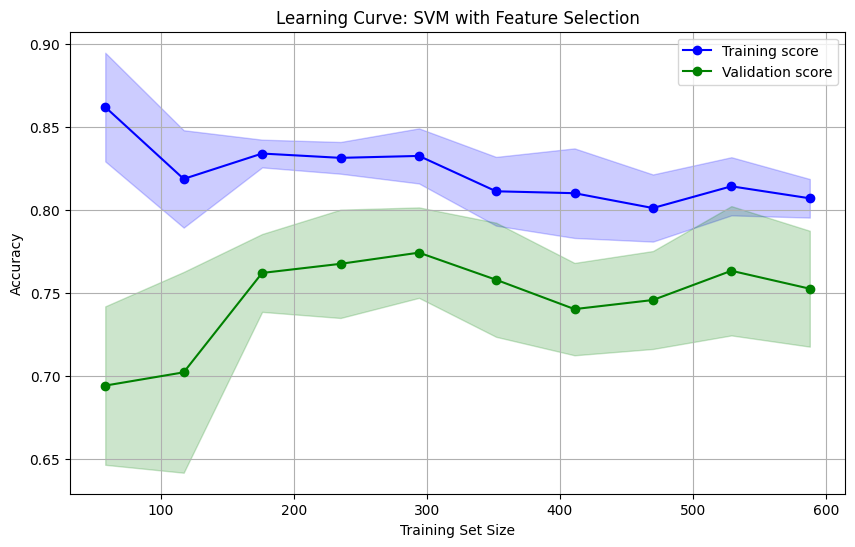

In [10]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

#Computing the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=svm_pipeline,
    X=X_train_encoded,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

#Calculating the means and standard deviations again
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plotting to see difference
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='green')

plt.title("Learning Curve: SVM with Feature Selection")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [11]:
#Interpretability using SHAP

import shap
import pandas as pd
import numpy as np

X_val_transformed = svm_pipeline[:-1].transform(X_val_encoded) #preprocessed input to SVM (X_val → SelectKBest + Scaler)

#Using a small background sample for KernelExplainer
background = shap.sample(X_val_transformed, 50, random_state=42)

# Now we can define SHAP KernelExplainer
explainer = shap.KernelExplainer(svm_pipeline.named_steps['svm'].predict_proba, background)

#Computing SHAP values for 50 validation samples
shap_values = explainer.shap_values(X_val_transformed[:50], nsamples=100)

selector = svm_pipeline.named_steps['select'] #feature names after SelectKBest (safe & robust)
selected_feature_indices = selector.get_support(indices=True)
all_feature_names = list(X_val_encoded.columns)
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]



  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
#Debugging check
print("shap_values type:", type(shap_values))
if isinstance(shap_values, list):
    print("shap_values[1] shape:", shap_values[1].shape)
print("X_val_transformed[:50] shape:", X_val_transformed[:50].shape)
print("selected_feature_names length:", len(selected_feature_names))


shap_values type: <class 'numpy.ndarray'>
X_val_transformed[:50] shape: (50, 30)
selected_feature_names length: 30


<Figure size 640x480 with 0 Axes>

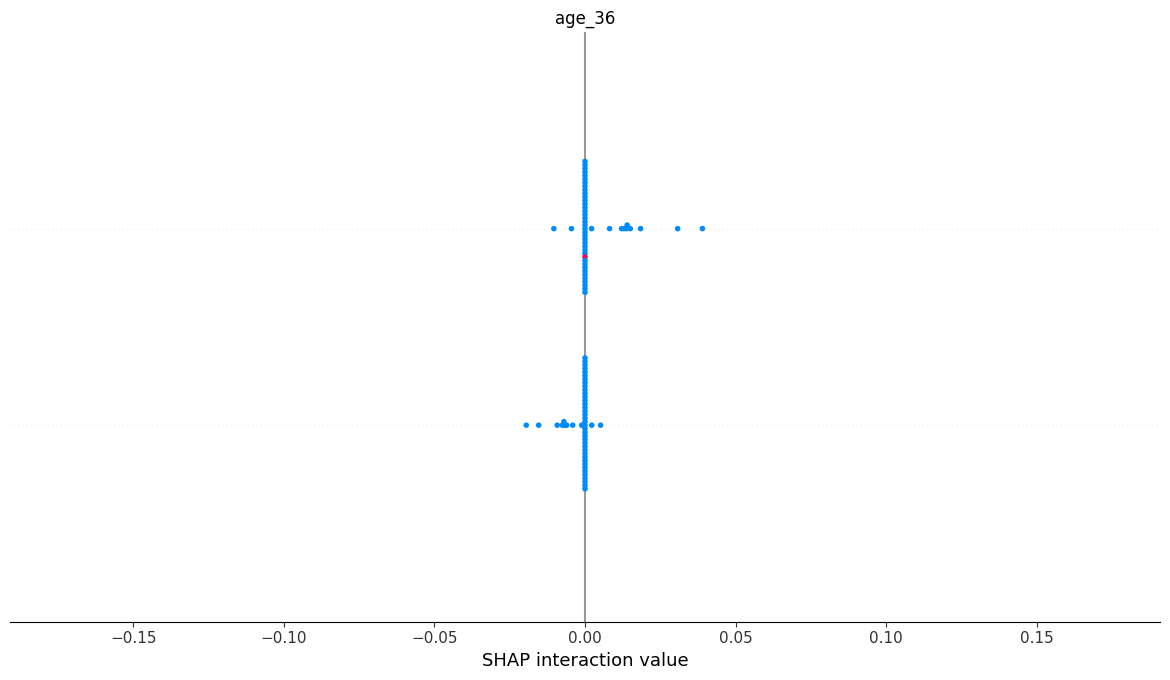

In [13]:
import pandas as pd
import shap

# Converting the transformed validation set to DataFrame with correct column names
X_val_shap_df = pd.DataFrame(X_val_transformed[:50], columns=selected_feature_names)

# Now plotting SHAP values with aligned features
shap.summary_plot(shap_values, X_val_shap_df)


## KNN

In [22]:
# Importing required libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Loading the dataset
df = pd.read_csv("/content/heart_disease_uci.csv")
y = df['num']
X = df.drop(columns=['num'])

# Imputing the missing values
imputer = SimpleImputer(strategy="most_frequent")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Encoding categorical features
X_encoded = pd.get_dummies(X_imputed)

# splitting into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=30) #(K=30 for baseline)

# Runnning the model
knn_model = KNeighborsClassifier(n_neighbors=5)


knn_pipeline = Pipeline([ ## Making the Pipeline
    ('select', selector),
    ('scale', StandardScaler()),
    ('knn', knn_model)
])

# Trainning
knn_pipeline.fit(X_train, y_train)

y_val_pred = knn_pipeline.predict(X_val) # Predict
y_val_proba = knn_pipeline.predict_proba(X_val)[:, 1]

print("\nValidation Metrics:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, average='macro'))
print("Recall   :", recall_score(y_val, y_val_pred, average='macro'))
print("F1 Score :", f1_score(y_val, y_val_pred, average='macro'))

# ROC AUC for binary or one-vs-rest multiclass probability
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y))
y_val_binarized = label_binarize(y_val, classes=np.unique(y))
roc_auc = roc_auc_score(y_val_binarized, knn_pipeline.predict_proba(X_val), average='macro', multi_class='ovr')
print("ROC AUC  :", roc_auc)




# print("\nValidation Metrics:")
# print("Accuracy :", accuracy_score(y_val, y_val_pred))
# print("Precision:", precision_score(y_val, y_val_pred))
# print("Recall   :", recall_score(y_val, y_val_pred))
# print("F1 Score :", f1_score(y_val, y_val_pred))
# print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))



Validation Metrics:
Accuracy : 0.5217391304347826
Precision: 0.31642410938051124
Recall   : 0.37659907204315857
F1 Score : 0.33174925951241735
ROC AUC  : 0.7454203050672107

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78        82
           1       0.46      0.51      0.48        53
           2       0.06      0.05      0.05        22
           3       0.09      0.05      0.06        21
           4       0.20      0.50      0.29         6

    accuracy                           0.52       184
   macro avg       0.32      0.38      0.33       184
weighted avg       0.50      0.52      0.51       184


Confusion Matrix:
[[64 12  5  1  0]
 [ 9 27  8  4  5]
 [ 5 11  1  3  2]
 [ 5  8  2  1  5]
 [ 0  1  0  2  3]]



 Validation Metrics:
Accuracy : 0.8315217391304348
Precision: 0.8141592920353983
Recall   : 0.9019607843137255
F1 Score : 0.8558139534883721
ROC AUC  : 0.9047704447632712

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80        82
           1       0.81      0.90      0.86       102

    accuracy                           0.83       184
   macro avg       0.84      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184

 Confusion Matrix:
[[61 21]
 [10 92]]


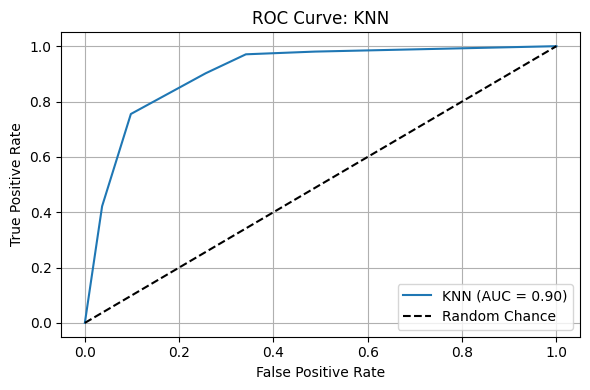

In [23]:
df = pd.read_csv("/content/heart_disease_uci.csv")

# Dropping irrelevant columns if present
for col in ["id", "dataset"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# Coverting multiclass to binary target: 0 = no disease, 1 = disease
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=["num"], inplace=True)

# One Hot encoding
df = pd.get_dummies(df, drop_first=True)

#Imputing missing values
imputer = SimpleImputer(strategy="mean")
X = df.drop("target", axis=1)
X_imputed = imputer.fit_transform(X)
y = df["target"]

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Splitting into tarining and validation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Building the KNN Model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test) #Predict
y_proba = knn.predict_proba(X_test)[:, 1]

print("\n Validation Metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plotting the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"KNN (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: KNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


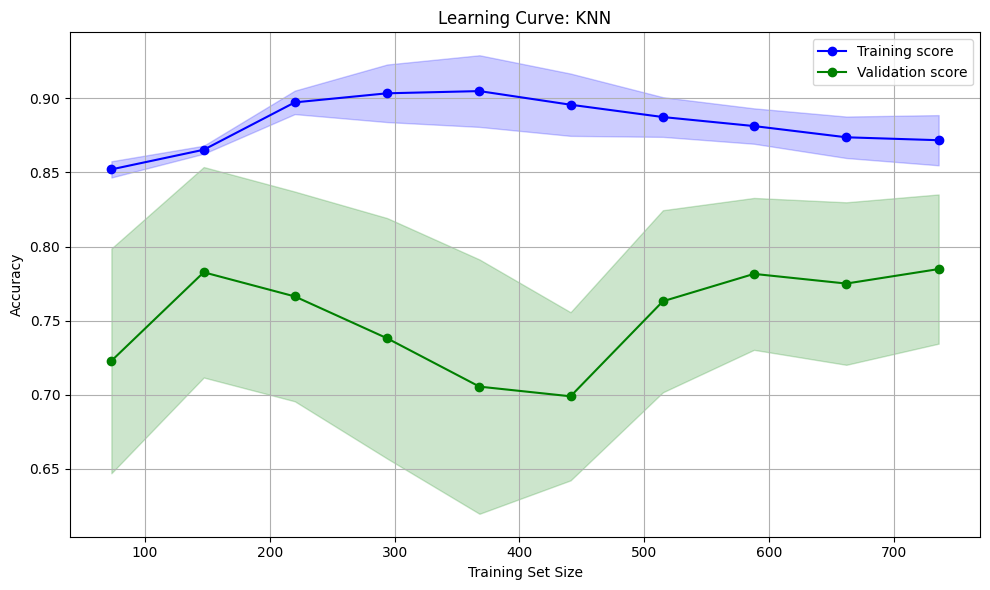

In [31]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=knn,
    X=X_scaled,
    y=y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score', color='blue')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation score', color='green')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='green')
plt.title("Learning Curve: KNN")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



 Validation Metrics:
Accuracy : 0.842391304347826
Precision: 0.8348623853211009
Recall   : 0.8921568627450981
F1 Score : 0.8625592417061612
ROC AUC  : 0.9168460066953612

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.82        82
           1       0.83      0.89      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

Confusion Matrix:
 [[64 18]
 [11 91]]


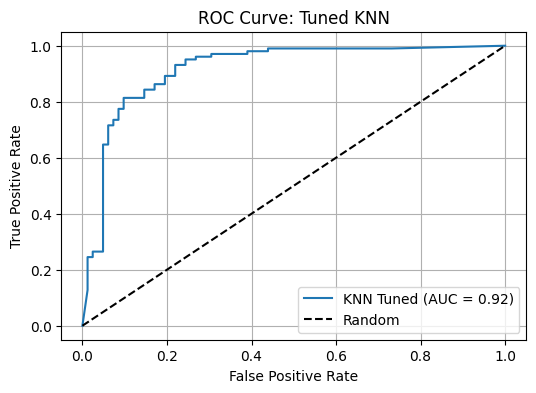

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("/content/heart_disease_uci.csv")
df.drop(columns=["id", "dataset"], inplace=True)
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=["num"], inplace=True)
df = pd.get_dummies(df, drop_first=True)

# Imputing and scaling
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(df.drop(columns=["target"]))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
y = df["target"]

# Splitting it into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# KNN with tuning
knn_tuned = KNeighborsClassifier(n_neighbors=17, weights='distance', p=1)
knn_tuned.fit(X_train, y_train)
y_pred = knn_tuned.predict(X_val)
y_proba = knn_tuned.predict_proba(X_val)[:, 1]

print("\n Validation Metrics:")
print("Accuracy :", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall   :", recall_score(y_val, y_pred))
print("F1 Score :", f1_score(y_val, y_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_proba))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Plotting the ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"KNN Tuned (AUC = {roc_auc_score(y_val, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Tuned KNN")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler

# Rebuilding the optimized pipeline
knn_optimized = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=20)),  # this time with fewer features
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15, weights='distance'))  # better generalization
])

# Retrainning and re-evaluating
knn_optimized.fit(X_train, y_train)
y_val_pred = knn_optimized.predict(X_val)
y_val_proba = knn_optimized.predict_proba(X_val)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))


Accuracy : 0.8641304347826086
Precision: 0.8532110091743119
Recall   : 0.9117647058823529
F1 Score : 0.8815165876777251
ROC AUC  : 0.9216284074605452


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=18. All the features will be returned.
  warnings.warn(


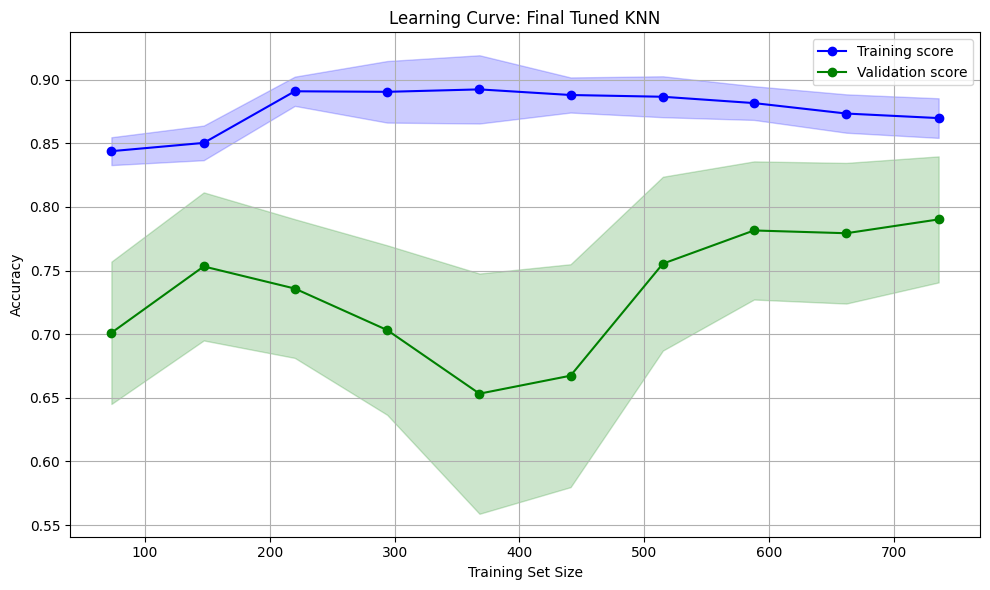

In [37]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Recomputing learning curve for the tuned KNN pipeline
train_sizes, train_scores, val_scores = learning_curve(
    estimator=knn_pipeline,  # final pipeline with tuned n_neighbors
    X=X_scaled,              # input features after scaling and imputation
    y=y,                     # binary target: 0 or 1
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculating the Mean and std deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='green')
plt.title("Learning Curve: Final Tuned KNN")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f278e068a6d722c55ae7bc1050d1868f9bcb4c34924d3ab0f4e0166ac3c69d3f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=18. All the features will be returned.
  warnings.warn(



 Validation Metrics:
Accuracy : 0.8152173913043478
Precision: 0.8640776699029126
Recall   : 0.8165137614678899
F1 Score : 0.839622641509434
ROC AUC  : 0.9021406727828746


  0%|          | 0/50 [00:00<?, ?it/s]

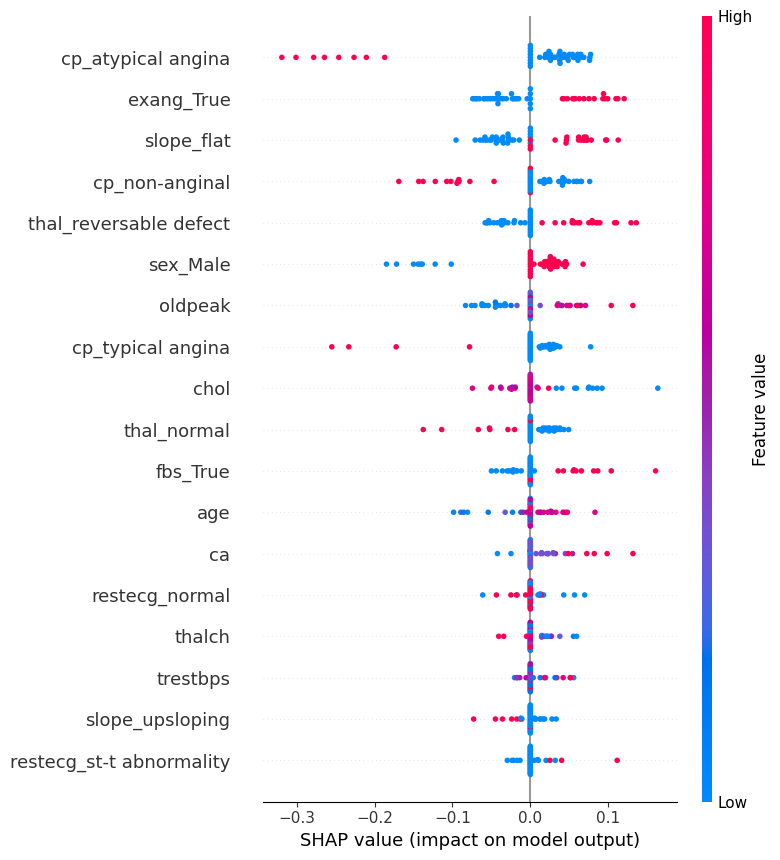

In [27]:
#Rerunning the whole code to get SHAP and Lime

import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


df = pd.read_csv("/content/heart_disease_uci.csv")
df = df.drop(columns=["id", "dataset"])
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=["num"], inplace=True)
df = pd.get_dummies(df, drop_first=True)

X = df.drop("target", axis=1)
y = df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputing the missing values
imputer = SimpleImputer(strategy="mean")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp = imputer.transform(X_val)

# Performing Feature selection
X_train_imp_df = pd.DataFrame(X_train_imp, columns=X.columns)
X_val_imp_df = pd.DataFrame(X_val_imp, columns=X.columns)

selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_sel = selector.fit_transform(X_train_imp_df, y_train)
X_val_sel = selector.transform(X_val_imp_df)

selected_features = X_train_imp_df.columns[selector.get_support()].tolist()

scaler = StandardScaler() # Scaling
X_train_scaled = scaler.fit_transform(X_train_sel)
X_val_scaled = scaler.transform(X_val_sel)

# KNN Model
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train_scaled, y_train)

# Evaluating again
y_val_pred = knn.predict(X_val_scaled)
y_val_proba = knn.predict_proba(X_val_scaled)[:, 1]

print("\n Validation Metrics:")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_val_proba))

# SHAP INTERPRETABILITY
X_val_df = pd.DataFrame(X_val_scaled, columns=selected_features)

explainer = shap.KernelExplainer(knn.predict_proba, shap.sample(X_train_scaled, 50, random_state=42))
shap_values = explainer.shap_values(X_val_scaled[:50], nsamples=100)

shap_matrix = np.stack(shap_values)[:, :, 1]  # shape = (n_samples, n_features)

# Plotting the SHAP
shap.summary_plot(shap_matrix, X_val_df.iloc[:50], feature_names=selected_features)

# LIME INTERPRETABILITY
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=selected_features,
    class_names=["No Disease", "Disease"],
    mode="classification"
)

# Trying to explain one prediction
i = 10
lime_exp = lime_explainer.explain_instance(
    data_row=X_val_scaled[i],
    predict_fn=knn.predict_proba
)

# Plotting the explanation
lime_exp.show_in_notebook(show_table=True)


## Gaussian Process Classifier

Validation Metrics:
Accuracy : 0.842391304347826
Precision: 0.8846153846153846
Recall   : 0.8440366972477065
F1 Score : 0.863849765258216
ROC AUC  : 0.91217125382263

 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        75
           1       0.88      0.84      0.86       109

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184


 Confusion Matrix:
[[63 12]
 [17 92]]


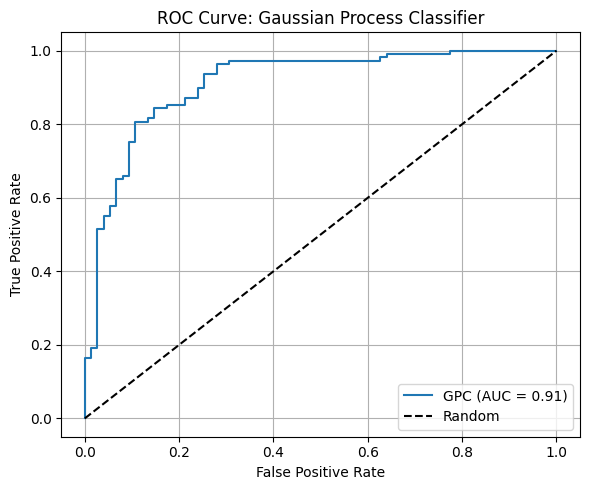

In [28]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve,
    precision_score, recall_score, classification_report, confusion_matrix
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Loading the dataset
df = pd.read_csv("/content/heart_disease_uci.csv")
df = df.drop(columns=["id", "dataset"])
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=["num"], inplace=True)
df = pd.get_dummies(df, drop_first=True)

# Handling the missing values and normalize
X = df.drop("target", axis=1)
y = df["target"]

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Splitting into training and validation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Making the Gaussian Process Classifier
gpc = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
gpc.fit(X_train, y_train)

y_pred = gpc.predict(X_test) # Evaluate
y_proba = gpc.predict_proba(X_test)[:, 1]

print("Validation Metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plotting the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"GPC (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Gaussian Process Classifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


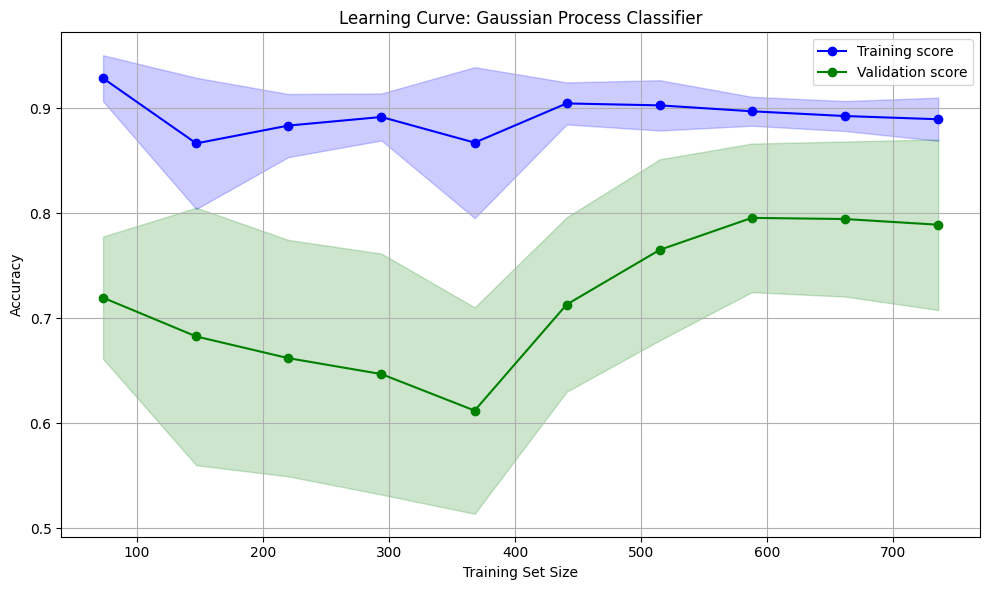

In [47]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

#Computing the learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0)),
    X=X_scaled,
    y=y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculating the Mean and Std Dev
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

plt.title("Learning Curve: Gaussian Process Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Validation Metrics:
Accuracy : 0.7934782608695652
Precision: 0.8514851485148515
Recall   : 0.7889908256880734
F1 Score : 0.819047619047619
ROC AUC  : 0.9006727828746177

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        75
           1       0.85      0.79      0.82       109

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.80      0.79      0.79       184


Confusion Matrix:
[[60 15]
 [23 86]]


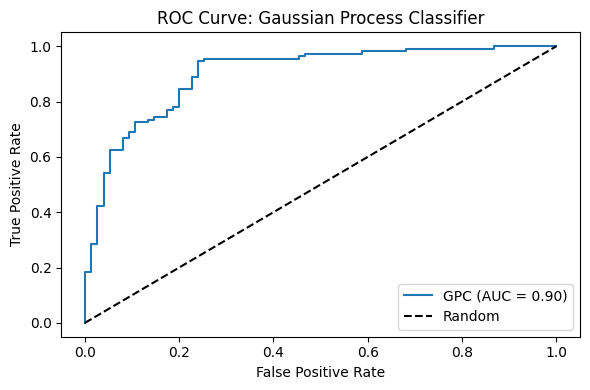

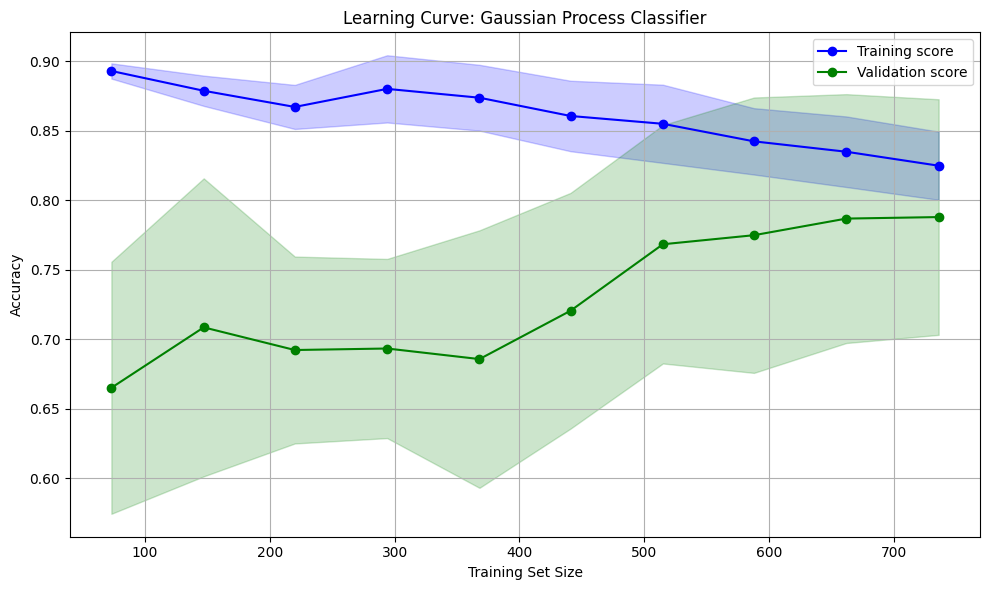

In [29]:
# Optimisting to reduce overfitting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)

warnings.filterwarnings("ignore")

# Dataset Load
df = pd.read_csv("/content/heart_disease_uci.csv")
df = df.drop(columns=["id", "dataset"])
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=["num"], inplace=True)
df = pd.get_dummies(df, drop_first=True)

# Preprocessing as before
X = df.drop("target", axis=1)
y = df["target"]

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_selected = selector.fit_transform(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# This time training Gaussian Process with simplified kernel
kernel = DotProduct() + WhiteKernel()
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
gpc.fit(X_train, y_train)

# Predicting
y_pred = gpc.predict(X_test)
y_proba = gpc.predict_proba(X_test)[:, 1]

print("Validation Metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plotting the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"GPC (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curve: Gaussian Process Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Calculating the Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=gpc,
    X=X_selected,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')
plt.title("Learning Curve: Gaussian Process Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP class 1 final shape: (50, 15)
Validation shape        : (50, 15)


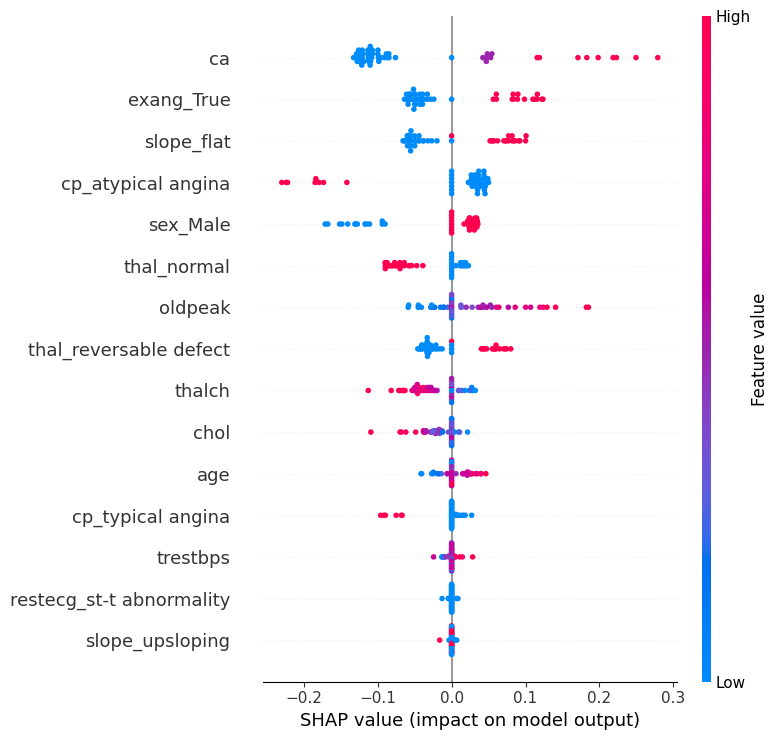

In [62]:
import shap

# Background for Kernel SHAP
X_bg = shap.sample(X_selected, 50, random_state=42)

explainer = shap.KernelExplainer(gpc_full.predict_proba, X_bg) # SHAP Explainer

# Computing SHAP values
shap_values = explainer.shap_values(X_selected[:50], nsamples=100) #This returns list of arrays per class

if shap_values[1].shape == (X_selected.shape[1], 2):
    shap_class_1 = np.array([row[:, 1] for row in shap_values])  # shape (50, 15)
else:
    shap_class_1 = shap_values[1]

print("SHAP class 1 final shape:", shap_class_1.shape)
print("Validation shape        :", X_selected[:50].shape)

# Assertting the values and plot
assert shap_class_1.shape == X_selected[:50].shape, "SHAP shape mismatch"
selected_feature_names = np.array(X.columns)[selector.get_support()] # Feature names

# Summary plot
shap.summary_plot(shap_class_1, X_selected[:50], feature_names=selected_feature_names)
